# Characterizing Lidar Point-Cloud Adversities Using a Vector Field Visualization

In [10]:

import open3d as o3d
import numpy as np
import plotly.graph_objects as go
import copy

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import time
import math
import ast

import plotly.figure_factory as ff

%load_ext autoreload
%autoreload 2
%autosave 180

# # Limit GPU memory, if running notebook on GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# if gpus:
#     try:
#         memlim = 2*1024
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
#     except RuntimeError as e:
#         print(e)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [11]:
# Import experimental data
ptCloud1_fn = "/home/daniel-choate/ASAR/s1/ErrorVectorFields/Cloud1_ExpD.txt"
ptCloud1_full = np.loadtxt(ptCloud1_fn)
# print(ptCloud1_full)
ptCloud10_fn = "/home/daniel-choate/ASAR/s1/ErrorVectorFields/Cloud10_ExpD.txt"
ptCloud10_full = np.loadtxt(ptCloud10_fn)
# print(ptCloud10_full)

In [12]:
# Remove nan from each point cloud 

# Filter out NaN points for ptCloud1
ptCloud1 = ptCloud1_full[~np.isnan(ptCloud1_full).any(axis=1)]
# print(ptCloud1)

# Filter out NaN points for ptCloud10
ptCloud10 = ptCloud10_full[~np.isnan(ptCloud10_full).any(axis=1)]
# print(ptCloud10)

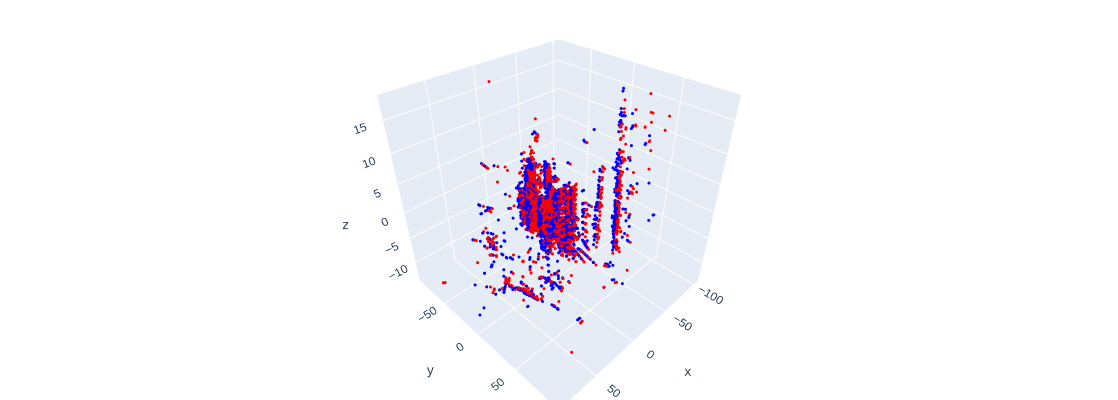

In [13]:
# Plot scans using open3d 

pcd1 = o3d.geometry.PointCloud()
points1 = ptCloud1
pcd1.points = o3d.utility.Vector3dVector(points1)
pcd1.paint_uniform_color([1, 0, 0])  # Red

pcd10 = o3d.geometry.PointCloud()
points10 = ptCloud10
pcd10.points = o3d.utility.Vector3dVector(points10)
pcd10.paint_uniform_color([0, 0, 1])  # Blue

o3d.visualization.draw_plotly([pcd1,pcd10])  #, point_size=3)




In [14]:

# FOR A WINDOW VISUALIZER
# Initialize Visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# # Optionally, set different colors for each point cloud
# pcd1.paint_uniform_color([1, 0, 0])  # Red
# pcd10.paint_uniform_color([0, 0, 1])  # Blue

# Add point clouds to the visualizer
vis.add_geometry(pcd1)
vis.add_geometry(pcd10)

# View control = vis.get_view_control()
# render_option = vis.get_render_option()

# render_option.background_color = [0.678, 0.847, 0.902] # Light blue
render_option.background_color = [1, 1, 1]

# Run the visualizer
vis.run()

# Destroy the window after use
vis.destroy_window()

# OR OPTIONALLY
# o3d.visualization.draw_geometries([pcd1, pcd10])

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 70
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 70
pci id for fd 70: 8086:a7a0, driver iris
MESA-LOADER: dlopen(/usr/lib/x86_64-linux-gnu/dri/iris_dri.so)
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using 

In [ ]:
# Align scans using ICP


# voxel_size = 0.05
# pcd1_down = pcd1.voxel_down_sample(voxel_size=voxel_size)
# pcd2_down = pcd2.voxel_down_sample(voxel_size=voxel_size)

source = pcd1
target = pcd10
max_corr_dist = .05
init = np.identity(4)
# Using initial esitmate of a translation in the y direction of 3m
init = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 3],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Perform ICP registration
result = o3d.pipelines.registration.registration_icp(source, target, max_corr_dist, init)
# # Or perform scan matching using RANSAC
# result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(source, target, o3d.pipelines.registration.FastGlobalRegistrationOption())

# Get the transformation matrix
Trans_matrix = result.transformation
print(Trans_matrix)

In [ ]:
# Apply transformation to cloud10 to align it with cloud1
pcd10_orig = pcd10
# ptCloud10_orig = ptCloud10
# pcd10 = pcd10.transform(T)
print(ptCloud10)
ptCloud10_homog = np.hstack((ptCloud10, np.ones((ptCloud10.shape[0], 1))))

ptCloud10 = ptCloud10_homog @ Trans_matrix.T
print(ptCloud10)
ptCloud10 = ptCloud10[:,:3]
print(ptCloud10)
pcd10 = o3d.geometry.PointCloud()
pcd10.points = o3d.utility.Vector3dVector(ptCloud10)
pcd10.paint_uniform_color([0, 0, 1])  # Blue

In [ ]:
# Plot newly aligned point clouds 1 and 10 
o3d.visualization.draw_plotly([pcd1,pcd10])  #, point_size=3)


In [ ]:
# # Import previously aligned scan 10 using NDT 

# ptCloud10_fn = "/home/daniel-choate/ASAR/s1/ErrorVectorFields/Cloud10Aligned_ExpD.txt"
# ptCloud10 = np.loadtxt(ptCloud10_fn)
# print(ptCloud10)


In [ ]:
# Convert point clouds to polar coordinates 

# Define initial position and final position 
initial_o = np.array([0, 0, 0])
final_o = np.array([Trans_matrix[0,3], Trans_matrix[1,3], Trans_matrix[2,3]])
print(final_o)
print(pcd1)

# Define function which converts a xyz point cloud to a polar cloud 
def conv_to_polar(ptCloud, origin):
    ptCloud_polar = np.zeros((len(ptCloud),3))
    # print(ptCloud_polar)
    print(ptCloud)
    for i in range(len(ptCloud)):
        X = ptCloud[i,0] + origin[0]
        # print(X)
        Y = ptCloud[i,1] + origin[1]
        # print(Y)
        Z = ptCloud[i,2] + origin[2]
        # print(Z)
        azi = np.arctan2(Y,X)
        # print(azi)
        rho = np.sqrt(X**2 + Y**2 + Z**2)
        # print(rho)
        elev = np.arctan(Z/(np.sqrt(X**2 + Y**2)))
        # print(elev)
        ptCloud_polar[i] = [azi, rho, elev]
    return ptCloud_polar



ptCloud1_pol = conv_to_polar(ptCloud1, initial_o)
ptCloud10_pol = conv_to_polar(ptCloud10, initial_o)



# Using origin as the center of polar coords

In [ ]:
# Divide polar clouds into spherical voxels based on azimuth and elevation 

# Set parameters of voxel distribution 
# Elevation
top_elev = 20
bot_elev = -20
elev_dif = top_elev - bot_elev
# Voxels divided around circumference
arc_d = 36
# Degrees per band elevation 
# NOTE: for VLP-16, 1 band every 2 degrees
dpb = 2
# Bands desired per azimuth voxel 
band_des = 16
deg_amt = band_des*dpb
# Voxels divided through elevation 
v_elev = np.ceil(elev_dif/deg_amt).astype(int)
# Voxels divided through azimuth 
v_az = np.ceil(360/arc_d).astype(int)

zero_el = 0 - bot_elev


# Define function to separate polar cloud to spherical voxels 
# Inputs: point clouds, arc length per voxel, amount of bands per elevation, ...
# total difference in elevation, point of zero elevation 
# Output: Voxel distribution 
def sph_vox_dist(ptCloud, arc_d, band_amt, elev_dif, zero_el):
    """ Voxel distribution 
    Inputs: point cloud, arc length per voxel in azimuth, amount of vertical bands
    of points for each elevation voxel, difference in total elevation, point of 
    zero elevation 
    Outputs: Voxels containing point indices based on their az,el location 
    """
    # Define number of voxels in the azimuth
    v_az = np.ceil(360/arc_d).astype(int)
    # print(v_az)
    v_elev = np.ceil(elev_dif/band_amt).astype(int)
    print(v_elev)
    voxels = np.empty((v_az, v_elev), dtype=object)
    for i in range(v_az):
        for j in range(v_elev):
            voxels[i,j] = []

    for q in range(len(ptCloud)):
        azi = np.degrees(ptCloud[q,0])
        rho = ptCloud[q,1]
        elev = np.degrees(ptCloud[q,2])
        # Create an indice for the azimuth and elevation 
        # Note: Theta (azimuth) goes from -pi to pi
        # Note: Elevation (elev) goes from specified range
        azVoxelInd = np.ceil((azi+180)/arc_d).astype(int);
        elevVoxelInd = np.ceil((elev + zero_el)/band_amt).astype(int);
        # Add an error check if zero value 
        # print(q)
        if azVoxelInd < 1: azVoxelInd = 1;
        else:
            voxels[azVoxelInd-1, elevVoxelInd-1].append(q)
        
    return voxels

Voxels1 = sph_vox_dist(ptCloud1_pol, arc_d, deg_amt, elev_dif, zero_el)
# print(Voxels1)
Voxels10 = sph_vox_dist(ptCloud10_pol, arc_d, deg_amt, elev_dif, zero_el)



# Pick a test voxel to check 
voxindaz = 8
voxindel = 0

test_pts1 = np.array(ptCloud1[Voxels1[voxindaz,voxindel]])
pcdtest1 = o3d.geometry.PointCloud()
pcdtest1.points = o3d.utility.Vector3dVector(test_pts1)
pcdtest1.paint_uniform_color([0, 1, 0])  # Green

test_pts10 = np.array(ptCloud10[Voxels10[voxindaz,voxindel]])
pcdtest10 = o3d.geometry.PointCloud()
pcdtest10.points = o3d.utility.Vector3dVector(test_pts10)
pcdtest10.paint_uniform_color([1, 1, 0])  # Green

# Plot newly aligned point clouds 1 and 10 
o3d.visualization.draw_plotly([pcd1,pcd10,pcdtest1,pcdtest10])  #, point_size=3)
height = 1000


In [ ]:
o3d.visualization.draw_geometries([pcd1, pcd10, pcdtest1, pcdtest10])

In [ ]:
# Mean calculations of points within each voxel 

def means_sph(Voxels, ptCloud, v_az, v_elev):
    """ Calculates the mean position x,y,z of each voxel
    for a specific point cloud 
    Inputs: Voxel distribution, point cloud, voxels in azimuth, 
    voxels in elevation 
    Outputs: Array of a mean point for each voxel based on that specific cloud 
    """
    voxels = np.empty((v_az, v_elev), dtype=object)
    for i in range(v_az):
        for j in range(v_elev):
            voxels[i,j] = []
    for i in range(v_az):
        for j in range(v_elev):
            x_m = ptCloud[Voxels[i,j],0]
            # print(x_m)
            y_m = ptCloud[Voxels[i,j],1]
            z_m = ptCloud[Voxels[i,j],2]
            mean_pt = [np.mean(x_m), np.mean(y_m), np.mean(z_m)]
            voxels[i,j] = mean_pt
            # print(i,j)
            # print(mean_pt)
    return voxels

means1 = means_sph(Voxels1, ptCloud1, v_az, v_elev)
means10 = means_sph(Voxels10, ptCloud10, v_az, v_elev)

# Mean difference calculation between each voxel

# Specify a minimum number of points as a threshold to calculate a mean 
min_pts = 20

def means_dif_sph(means1, means2, voxels1, voxels2, v_az, v_elev, min_pts):
    """ Calculates the difference in means for each voxel for the separate pt clouds
    Inputs: mean points from cloud 1, mean points from cloud 2, voxel distribution 
    of cloud 1, voxel distribution of cloud 2, voxels in the azimuth, voxels in the
    elevation, minimum point threshold 
    Outputs: Mean point difference 
    """
    means_dif = np.empty((v_az, v_elev), dtype=object)
    for i in range(v_az):
        for j in range(v_elev):
            means_dif[i,j] = []

    for i in range(v_az):
        for j in range(v_elev):
            if len(voxels1[i,j]) >= min_pts and len(voxels2[i,j]) >= min_pts:
                x_dif = means2[i,j][0] - means1[i,j][0]
                y_dif = means2[i,j][1] - means1[i,j][1]
                z_dif = means2[i,j][2] - means1[i,j][2]
                mean_dif_pt = [x_dif, y_dif, z_dif]
                # print(mean_dif_pt)
                means_dif[i,j] = mean_dif_pt
            else:
                means_dif[i,j] = [0,0,0]
    return means_dif

means_dif = means_dif_sph(means1, means10, Voxels1, Voxels10, v_az, v_elev, min_pts)
# print(means_dif)

In [ ]:
# Set up quiver plot distribution 

def quiv_i(vox_number, means, v_az, v_elev, pos):
    """ Setup for quiver plot format
    Inputs: number of total voxels, means (or mean dif) of 
    point cloud within each voxel, voxels in azimuth, voxels
    in elevation, position (x,y, or z)
    Outputs: Array of position or distance for quiver plotting
    """
    q_i = np.zeros((vox_number,1))
    ind = 0
    for i in range(v_az):
        for j in range(v_elev):
            position_ii = means[i,j][pos]
            # print(position_ii)
            q_i[ind] = position_ii
            ind += 1
    q_i = q_i[:,0]
    return q_i

vox_number = v_az*v_elev

X_q = quiv_i(vox_number, means1, v_az, v_elev, 0)
Y_q = quiv_i(vox_number, means1, v_az, v_elev, 1)
Z_q = quiv_i(vox_number, means1, v_az, v_elev, 2)
U_q = quiv_i(vox_number, means_dif, v_az, v_elev, 0)
V_q = quiv_i(vox_number, means_dif, v_az, v_elev, 1)
W_q = quiv_i(vox_number, means_dif, v_az, v_elev, 2)

print(X_q)



In [6]:
# Create a Plotly figure to show quiver plot 
# ATTEMPT 1
fig = go.Figure()
arrowhead_length = 1
arrowhead_width = 0.5

# Add vectors as lines
for i in range(len(X_q)):
    print(X_q[i])
    fig.add_trace(go.Scatter3d(
        x=[X_q[i], X_q[i] + U_q[i]],
        y=[Y_q[i], Y_q[i] + V_q[i]],
        z=[Z_q[i], Z_q[i] + W_q[i]],
        mode='lines',
        line=dict(color='blue', width=5),
        name=f'Vector {i+1}'
    ))

     # Normalize direction vector
    norm = np.sqrt(U_q[i]**2 + V_q[i]**2 + W_q[i]**2)
    U_q_norm, V_q_norm, W_q_norm = U_q[i] / norm, V_q[i] / norm, W_q[i] / norm

    # Calculate arrowhead points
    # Define the arrowhead
    arrowhead_points = [
        (U_q_norm, V_q_norm, W_q_norm),
        (-U_q_norm + arrowhead_width * (V_q_norm - W_q_norm), -V_q_norm + arrowhead_width * (W_q_norm - U_q_norm), -W_q_norm + arrowhead_width * (U_q_norm - V_q_norm)),
        (-U_q_norm - arrowhead_width * (V_q_norm + W_q_norm), -V_q_norm - arrowhead_width * (W_q_norm + U_q_norm), -W_q_norm - arrowhead_width * (U_q_norm + V_q_norm))
    ]

    # Arrowhead lines
    for j in range(1, len(arrowhead_points)):
        fig.add_trace(go.Scatter3d(
            x=[X_q[i] + U_q[i], X_q[i] + U_q[i] + arrowhead_points[j][0]],
            y=[Y_q[i] + V_q[i], Y_q[i] + V_q[i] + arrowhead_points[j][1]],
            z=[Z_q[i] + W_q[i], Z_q[i] + W_q[i] + arrowhead_points[j][2]],
            mode='lines',
            line=dict(color='blue', width=2),
            name=f'Arrowhead {i+1} Side {j}'
        ))

# Update layout
fig.update_layout(
    title='3D Quiver Plot',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        # height = 1000
    ),
    showlegend=False
    
)

# Show the figure
fig.show()

NameError: name 'X_q' is not defined

In [ ]:
# Attempt 2
ax = plt.figure().add_subplot(projection='3d')

ax.quiver(X_q, Y_q, Z_q, U_q, V_q, W_q, length=1) #, normalize=True)

plt.show()